In [39]:
# Import the required libraries

import torch
import os
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
import torch.utils.data
from torchvision import transforms
from torch.nn.functional import interpolate
import torch.nn as nn
from torch.autograd import Variable
import math
import numpy as npP
from natsort import natsorted
from PIL import Image
import random

In [40]:
# Code to upload dataset to google colab

from google.colab import drive
drive.mount('/content/drive')

import zipfile

path_to_zip_file = 'drive/MyDrive/data.zip'
directory_to_extract_to = 'VISCHEMA_PLUS/'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

!cp "drive/MyDrive/viscplus_train.csv" "VISCHEMA_PLUS/"
!cp "drive/MyDrive/viscplus_val.csv" "VISCHEMA_PLUS/"

ModuleNotFoundError: No module named 'google'

In [ ]:
# Create datasets and dataloaders

import pandas as pd

class VISCHEMA_PLUS(Dataset):
    def __init__(self, dataset_dir = 'VISCHEMA_PLUS/', image_dir = 'images/', label_dir = 'vms/', train = True, transform = None):
        
        if train:
            train_csv = pd.read_csv(f"{dataset_dir}viscplus_train.csv", header = None)
            all_images = train_csv[0].values.tolist()
        else:
            val_csv = pd.read_csv(f"{dataset_dir}viscplus_val.csv" , header = None)
            all_images = val_csv[0].values.tolist()
            
        self.transform = transform
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.dataset_dir = dataset_dir
        
        self.all_images = natsorted(all_images)
        
    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):    
        convert_tensor = transforms.ToTensor()
        
        image = Image.open(f"{self.dataset_dir}{self.image_dir}{self.all_images[idx]}").convert("RGB")
        image = convert_tensor(image)

        label = Image.open(f"{self.dataset_dir}{self.label_dir}{self.all_images[idx]}").convert("RGB")
        label = convert_tensor(label)
        
        if self.transform != None:
            image = self.transform(image)
            label = self.transform(label)
            
        return image, label

image_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.Normalize(0.5,0.5)
])

batch_size = 8

train_dataset = VISCHEMA_PLUS(transform = image_transforms, train=True)
val_dataset   = VISCHEMA_PLUS(transform = image_transforms, train=False)

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
val_loader   = DataLoader(dataset = val_dataset,   batch_size = batch_size, shuffle=True)

print(f'{len(train_dataset)} Items in Train dataset')
print(f'{len(val_dataset)}  Items in Validation dataset')

1280 Items in Train dataset
320  Items in Validation dataset


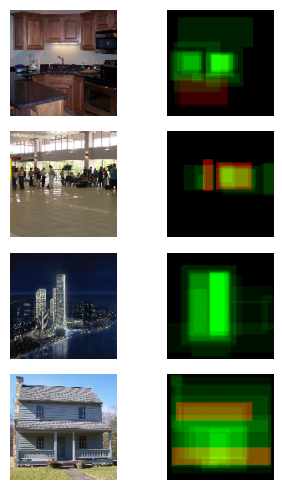

In [ ]:
# Examine some image label pairs

import matplotlib.pyplot as plt

figure = plt.figure(figsize=(5,5))
cols, rows = 3, 4
for i in range(rows):
    
    images, labels = next(iter(train_loader))
    
    # The image
    figure.add_subplot(rows,cols, cols*i+1)
    plt.axis("off")
    plt.imshow((images[0].squeeze().permute(1, 2, 0) +1 )/2 )
    
    # The Label
    figure.add_subplot(rows,cols, cols*i+2)
    plt.axis("off")
    plt.imshow((labels[0].squeeze().permute(1, 2, 0) +1 )/2)
    
plt.tight_layout()
plt.show()

In [ ]:
# Generator Model

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, norm = True, norm_func = nn.InstanceNorm2d):
        super().__init__()
        if norm:
            self.main = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,3,padding=1),
                nn.ReLU(),
                norm_func(out_channels),
                nn.Conv2d(out_channels,out_channels,3,padding=1),
                nn.ReLU(),
                norm_func(out_channels),
            )
        else:
            self.main = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,3,padding=1),
                nn.ReLU(),
                nn.Conv2d(out_channels,out_channels,3,padding=1),
                nn.ReLU(),
                norm_func(out_channels),
            )
    def forward(self, x):
        return self.main(x)
    
class Encoder(nn.Module):
    def __init__(self, channels=(3,64,128,256,512), norm_func = nn.InstanceNorm2d):
        super().__init__()
        self.encoding_blocks = nn.ModuleList(
            [Block(channels[i], channels[i+1], norm = (i != 0), norm_func = norm_func) for i in range(len(channels)-1)]
        )
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        features = []
        
        for block in self.encoding_blocks:
            x = block(x)
            features.append(x)
            x = self.pool(x)
                 
        return features
        
class Decoder(nn.Module):
    def __init__(self, channels=(512,256,128,64), norm_func = nn.InstanceNorm2d):
        super().__init__()
        self.channels = channels
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(self.channels[i], self.channels[i+1],2,2) for i in range(len(channels)-1)])
        self.decoder_blocks = nn.ModuleList(
            [Block(channels[i], channels[i+1], norm_func = norm_func) for i in range(len(channels)-1)]
        )
    
    def forward(self, x, encoder_features):
        for i in range(len(self.channels)-1):
            x = self.upconvs[i](x)
            features = self.crop(encoder_features[i], x)
            x = torch.cat([x, features], dim=1)
            x = self.decoder_blocks[i](x)
        return x
    
    def crop(self, features, x):
        _, _, height, width = x.shape
        features = transforms.CenterCrop([height, width])(features)
        return features
        
class Generator(nn.Module):
    def __init__(self, 
                 encode_channels=(3,64,128,256,512,1024), 
                 decode_channels=(1024,512,256,128,64), 
                 num_class=3, 
                 retain_dim=True, 
                 output_size=(572,572),
                 norm_func = nn.InstanceNorm2d):
        
        super(Generator, self).__init__()
        
        self.encoder = Encoder(encode_channels, norm_func = norm_func)
        self.decoder = Decoder(decode_channels, norm_func = norm_func)
        
        self.head = nn.Conv2d(decode_channels[-1], num_class, 1)
        
        """# Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)"""

    def forward(self, x):
        
        encoding_features = self.encoder(x)
        decoding_features = self.decoder(encoding_features[::-1][0], encoding_features[::-1][1:])
        output = self.head(decoding_features)
        output = nn.Tanh()(output)
        
        return output

model = Generator()

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_params} Parameters in UNet Generator')

images, _ = next(iter(train_loader))
output = model(images)    val_score = train_GAN(generator, discriminator,optim_g,optim_d,save_dir)

print(output.shape)

del model, output, images

31031875 Parameters in UNet Generator
torch.Size([8, 3, 128, 128])


In [ ]:
# Discriminator Model

class Discriminator(nn.Module):
    def __init__(self, norm_func = nn.BatchNorm2d, channels = (6,64,128,256,512,1024)):
        super(Discriminator, self).__init__()
        
        def Block(in_channels, out_channels, norm=True):
          val_score = train_GAN(generator, discriminator,optim_g,optim_d,save_dir)
      layers = [nn.Conv2d(in_channels, out_channels, 4,stride=2, padding=1)]
            if norm:
                layers.append(norm_func(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *Block(channels[0],channels[1], norm = False),
            *Block(channels[1],channels[2]),
            *Block(channels[2],channels[3]),
            *Block(channels[3],channels[4]),
            *Block(channels[4],channels[5]),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(channels[5],1,4,padding=1, bias=False)
        )
        
    def forward(self, images, labels):
        image_input = torch.cat((images, labels), 1)
        return self.model(image_input)

model = Discriminator()

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_params} Parameters in Discriminator')

images, labels = next(iter(train_loader))
output = model(images, labels)
print(output.shape)

del model, output, images

11169472 Parameters in Discriminator
torch.Size([8, 1, 4, 4])


In [ ]:
# Set up our training environment

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
patch = (1, 4, 4)

net_G = Generator()
net_D = Discriminator()

net_G, net_D = net_G.to(device), net_D.to(device)

criterion_GAN = nn.MSELoss()
criterion_pixelwise = nn.L1Loss() 

train_losses = []
val_losses = []

# Loss weight of L1 pixel-wise loss between translated image and real image
# This value is copied from the PIX2PIX architecture
lambda_pixel = 100

optim_G = torch.optim.Adam(net_G.parameters(), lr=0.0001, betas = (0,0.9))
optim_D = torch.optim.Adam(net_D.parameters(), lr=0.0001, betas = (0,0.9))
num_epochs = 100

In [ ]:
# Train our networks

print('Starting Training')
for epoch in range(num_epochs):
    
    # Go into training mode
    net_D.train()
    net_G.train()
    
    # Train the model and evaluate on the training set
    total_train_loss = 0
    total_val_loss = 0

    for i, (images, real_labels) in enumerate(train_loader):

        # Adversarial ground truths
        valid = torch.ones((images.size(0), *patch)).to(device)
        fake = torch.zeros((images.size(0), *patch)).to(device)

        # Move images to device and create an image prediction
        images, real_labels = images.to(device), real_labels.to(device)
        
        ###################
        # Train Generator #
        ###################

        optim_G.zero_grad()
        
        # GAN Loss
        
        fake_labels = net_G(images)
        pred_fake = net_D(fake_labels, images)
        loss_GAN = criterion_GAN(pred_fake, valid)
        loss_pixel = criterion_pixelwise(fake_labels, real_labels)
        
        # Logging
        batch_loss = loss_pixel.item() * batch_size
        total_train_loss += batch_loss
        
        loss_G = loss_GAN + lambda_pixel * loss_pixel
        
        loss_G.backward()
        optim_G.step()

        #######################
        # Train Discriminator #
        #######################

        optim_D.zero_grad()
        
        # Real Loss
        pred_real = net_D(real_labels, images)
        loss_real = criterion_GAN(pred_real, valid)
        
        # Fake Loss
        pred_fake = net_D(fake_labels.detach(), images)
        loss_fake = criterion_GAN(pred_fake, fake)
        
        # Total Loss
        loss_D = 0.5 * (loss_real + loss_fake)
        
        loss_D.backward()
        optim_D.step()

        # Clear memory
        del images, real_labels, fake_labels 
        torch.cuda.empty_cache() 
    
    net_G.eval()
    with torch.no_grad():
      for i, (images, real_labels) in enumerate(val_loader):

          # Adversarial ground truths
          valid = torch.ones((images.size(0), *patch)).to(device)
          fake = torch.zeros((images.size(0), *patch)).to(device)

          # Move images to device and create an image prediction
          images, real_labels = images.to(device), real_labels.to(device)
          
          #########################
          # Test Generator On Val #
          #########################
          
          # GAN Loss
          
          fake_labels = net_G(images)
          loss_pixel = criterion_pixelwise(fake_labels, real_labels)
          batch_loss = loss_pixel.item() * batch_size
          total_val_loss += batch_loss
          
          # Clear memory
          del images, real_labels, fake_labels 
          torch.cuda.empty_cache() 

    train_losses.append( total_train_loss/ len(train_loader))
    val_losses.append( total_val_loss / len(val_loader))
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], D: {loss_D.item():.4f}, G: {loss_G.item():.4f},  Val Loss: {val_losses[-1]} Train Loss: {train_losses[-1]}')

    if epoch % 25 == 0:
      torch.save(net_D.state_dict(), f'weights-NETD-1-{epoch}.pkl')
      torch.save(net_G.state_dict(), f'weights-NETG-1-{epoch}.pkl')

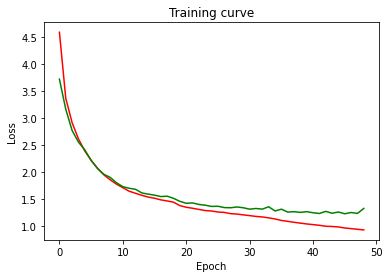

In [ ]:
# Plot our training curves

plt.title("Training curve")

plt.plot(range(len(train_losses)),train_losses,'r')
plt.plot(range(len(val_losses)),val_losses,'g')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

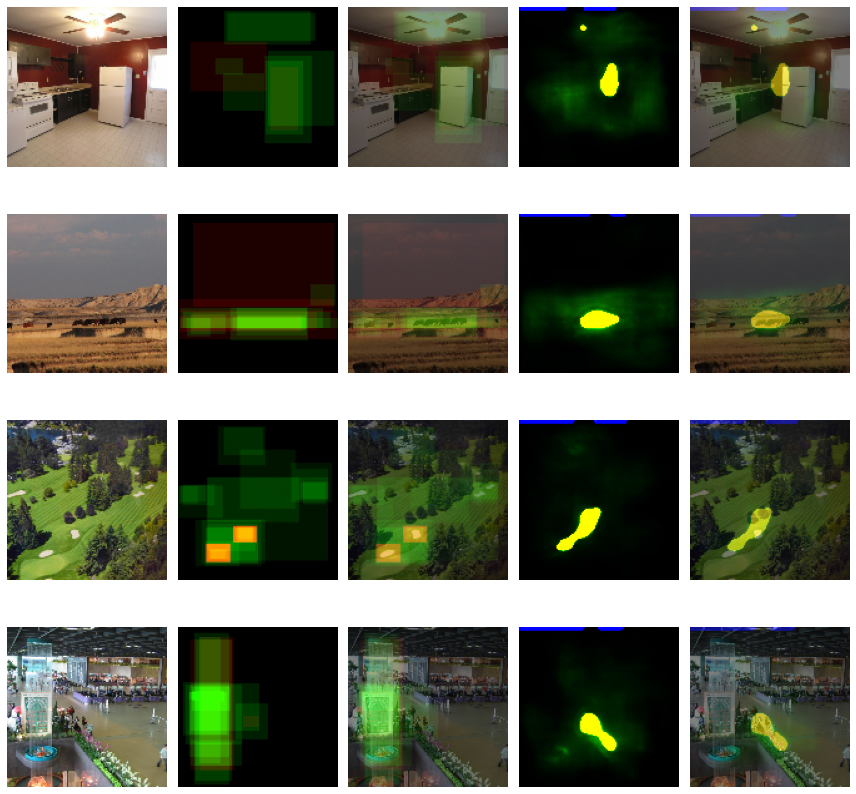

In [ ]:
# Visualise Output of Generator

import matplotlib.pyplot as plt

images, labels = next(iter(val_loader))
figure = plt.figure(figsize=(12,12))
output = net_G(images)

cols, rows = 5, 4
for i in range(rows):

    figure.add_subplot(rows,cols, cols*i+1)
    plt.axis("off")
    plt.imshow((images[i].cpu().detach().squeeze().permute(1, 2, 0) +1 )/ 2 )
    
    figure.add_subplot(rows,cols, cols*i+2)
    plt.axis("off")
    plt.imshow((labels[i].cpu().detach().squeeze().permute(1, 2, 0) +1 )/ 2 )  

    figure.add_subplot(rows,cols, cols*i+3)
    plt.axis("off")
    plt.imshow(((torch.add(images, labels))[i].cpu().detach().squeeze().permute(1, 2, 0) +2 )/ 4 )

    figure.add_subplot(rows,cols, cols*i+4)
    plt.axis("off")
    plt.imshow((output[i].cpu().detach().squeeze().permute(1, 2, 0) +1 )/ 2 )  

    figure.add_subplot(rows,cols, cols*i+5)
    plt.axis("off")
    plt.imshow(((torch.add(images, output))[i].cpu().detach().squeeze().permute(1, 2, 0) +2 )/ 4 )
plt.tight_layout()
plt.show()

In [ ]:
#  Set up testing environment

norm_functions = [nn.BatchNorm2d, nn.InstanceNorm2d, nn.LayerNorm]

generator_channels = [
    {'encode':(3,64 ,128,256,512,1024) , 'decode':(1024,512,256,128,64 )},
    {'encode':(3,32 ,64 ,128,256,512 ) , 'decode':(512 ,256,128,64 ,32 )},
    {'encode':(3,50 ,100,200,400,800 ) , 'decode':(800 ,400,200,100,50 )},
    {'encode':(3,100,200,400,800,1600) , 'decode':(1600,800,400,200,100)}
]
discriminator_channels = [
    (6,64 ,128,256,512,1024),
    (6,32 ,64 ,128,256,512 ),
    (6,50 ,100,200,400,800 ),
    (6,100,200,400,800,1600),
]
generator_optimisers = [
    torch.optim.Adam,
    torch.optim.Adadelta,
    torch.optim.Adagrad,
    torch.optim.SGD
]
discriminator_optimisers = generator_optimisers[:]

learning_rates = [0.0001,0.0005,0.001,0.00005,0.0002,0.005,1,0.5,0.25,0.1,0.01,0.001, 0.005]

adam_betas = [(0.9, 0.999), (0, 0.999), (0.5, 0.999)]

In [ ]:
from train import train_GAN

def log(string_to_log):
    file = open("log.txt", "a")
    file.write(f"{string_to_log} \n")
    file.close()

# Iterate over different parameters
# Iterating over every parameter combination would be ideal but it would also require an insane amount of runs
# Instead we will iterate over every parameter, pick the one that gives the best result and go through each option until we find the best
# Instead of O(n^2) runs this will require O(n) runs (i think)
# i.e. 10s of tests rather than 1000s

iteration_counter = 0
iteration_dictionary = {}

# Test Norm Functions
best_norm_func_d = None
best_norm_func_g = None
best_norm_score = 100000000
for (norm_func_d,norm_func_g) in [(norm_func_d, norm_func_g) for norm_func_d in norm_functions for norm_func_g in norm_functions]:
    
    # Set up environment
    generator = Generator(norm_func = norm_func_d)
    discriminator = Discriminator(norm_func = norm_func_d)
    optim_g = torch.optim.Adam(generator.parameters())
    optim_d = torch.optim.Adam(discriminator.parameters())
    save_dir = iteration_counter
    iteration_dictionary[iteration_counter] = f"Discriminator Norm Func = {norm_func_d}, Generator Norm Func = {norm_func_g}" 
    
    # train with each norm function combo
    val_score = train_GAN(generator, discriminator,optim_g,optim_d,save_dir)

    log(f"Norm Func Generator = {norm_func_g}, Discriminator = {norm_func_d}, val_score = {val_score}")

    if val_score < best_norm_score:
        best_norm_func_g = norm_func_g
        best_norm_func_d = norm_func_d
        best_norm_score = val_score

    # Increment Counter
    iteration_counter += 1

# Test Channels
best_generator_channels_pair = None
best_discrminator_channels = None
best_channel_score = 100000000
for (g, d) in [(g,d) for g in generator_channels for d in discriminator_channels]:
    
    # Set up environment
    generator = Generator(norm_func = best_norm_func_g, decode_channels=g['decode'], encode_channels=g['encode'] )
    discriminator = Discriminator(norm_func = best_norm_func_d, channels=d)
    optim_g = torch.optim.Adam(generator.parameters())
    optim_d = torch.optim.Adam(discriminator.parameters())
    save_dir = iteration_counter
    iteration_dictionary[iteration_counter] = f"Gen Channels = {g}, Disc Channels = {d}" 
    
    # train with each channel combo
    val_score = train_GAN(generator, discriminator,optim_g,optim_d,save_dir)

    log(f"Gen Channels = {g}, Disc Channels = {d}, Val = {val_score}")

    if val_score < best_channel_score:
        best_generator_channels_pair = g
        best_discrminator_channels = d
        best_channel_score = val_score

    # Increment Counter
    iteration_counter += 1

# Test Optim Functions
best_optim_g = None
best_optim_d = None
best_optim_score = 100000000
for (g,d) in [(g,d) for g in generator_optimisers for d in discriminator_optimisers]:
    
    # Set up environment
    generator = Generator(norm_func = best_norm_func_g, decode_channels=best_generator_channels_pair['decode'], encode_channels=best_generator_channels_pair['encode'] )
    discriminator = Discriminator(norm_func = best_norm_func_d, channels=best_discrminator_channels)
    optim_g = g(generator.parameters())
    optim_d = d(discriminator.parameters())
    save_dir = iteration_counter
    iteration_dictionary[iteration_counter] = f"Gen optim = {g}, Disc optim = {d}" 
    
    # train with each optim combo
    val_score = train_GAN(generator, discriminator,optim_g,optim_d,save_dir)

    log(f"Gen optim = {g}, Disc optim = {d}, Val = {val_score}")

    if val_score < best_channel_score:
        best_optim_g = g
        best_optim_d = d
        best_optim_score = val_score

    # Increment Counter
    iteration_counter += 1

# Test Learning Rates
best_LR_g = None
best_LR_d = None
best_LR_score = 100000000000
for (LR_d, LR_d) in [(LR_d, LR_g) for LR_d in learning_rates for LR_g in learning_rates]:

    # Set up environment
    generator = Generator(norm_func = best_norm_func_g, decode_channels=best_generator_channels_pair['decode'], encode_channels=best_generator_channels_pair['encode'] )
    discriminator = Discriminator(norm_func = best_norm_func_d, channels=best_discrminator_channels)
    optim_g = g(generator.parameters(), lr=LR_g)
    optim_d = d(discriminator.parameters(), lr=LR_d)
    save_dir = iteration_counter
    iteration_dictionary[iteration_counter] = f"Gen LR = {LR_g}, Disc LR = {LR_d}" 
    
    # train with each optim combo
    val_score = train_GAN(generator, discriminator,optim_g,optim_d,save_dir)

    log(f"Gen LR = {LR_g}, Disc LR = {LR_d}, Val = {val_score}")

    if val_score < best_LR_score:
        best_LR_g = LR_g
        best_LR_d = LR_d
        best_LR_score = val_score

    # Increment Counter
    iteration_counter += 1

# Test Adam Betas
if (best_optim_g == torch.optim.Adam or best_optim_d == torch.optim.Adam):
    best_Adam_Betas_g = None
    best_Adam_Betas_d = None
    best_betas_score  = 100000000
    for (g,d) in [(g,d) for g in adam_betas for d in adam_betas]:
        # Set up environment
        generator = Generator(norm_func = best_norm_func_g, decode_channels=best_generator_channels_pair['decode'], encode_channels=best_generator_channels_pair['encode'] )
        discriminator = Discriminator(norm_func = best_norm_func_d, channels=best_discrminator_channels)
        optim_g = g(generator.parameters(), lr=best_LR_g, betas=g)
        optim_d = d(discriminator.parameters(), lr=best_LR_d, betas=d)
        save_dir = iteration_counter
        iteration_dictionary[iteration_counter] = f"Gen Adam Betas = {g}, Disc Adam Betas = {d}" 
        
        # train with each beta combo
        val_score = train_GAN(generator, discriminator,optim_g,optim_d,save_dir)

        log(f"Gen adam beta = {g}, Disc adam beta = {d}, Val = {val_score}")

        if val_score < best_LR_score:
            best_LR_g = LR_g
            best_LR_d = LR_d
            best_LR_score = val_score

        # Increment Counter
        iteration_counter += 1

14
